In [9]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
from torchsummary import summary

def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

### 1. Why are there two 1x1 convolutional layers per NiN block? Increase their number to three. Reduce their number to one. What changes?

In [6]:
def nin_block_new(num_1x1, out_channels, kernel_size, strides, padding):
    layers = []
    for _ in range(num_1x1):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=1))
        layers.append(nn.ReLU())
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        *layers)

class NiN_new(d2l.Classifier):
    def __init__(self, num_1x1=2, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block_new(num_1x1, 96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block_new(num_1x1, 256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block_new(num_1x1, 384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block_new(num_1x1, num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

(1) two 1x1 convolutional layers

accuracy  0.87203324


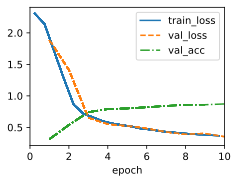

In [7]:
model = NiN_new(num_1x1=2, lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

(2) one 1x1 convolutional layer

accuracy  0.77511865


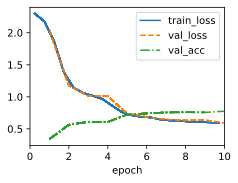

In [11]:
model = NiN_new(num_1x1=1, lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

(3) three 1x1 convolutional layer

accuracy  0.63726264


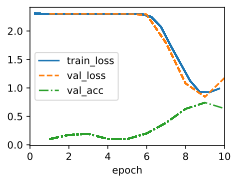

In [12]:
model = NiN_new(num_1x1=3, lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

From the result, two 1x1 convolution has the best result. For one 1x1 block, the accuracy decreases, which may because the model is less expressive. For three 1x1 convoluion, it becomes harder to train. (Besides, I trained the model with the same hyperparameters for several times and the result is quite different.) With more 1x1 convolutional layers, the model can capture more complex relationships between features and enable better representation learning. However, there will be more parameters and more computational cost. And it will be more easily to be overfitted.

### 2. What changes if you replace the 1x1 convolutions by 3x3 convolutions?

accuracy  0.8710443


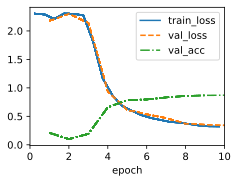

In [25]:
def nin_block_3x3(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=3, padding=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=3, padding=1), nn.ReLU())

class NiN_3x3(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block_3x3(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block_3x3(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block_3x3(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block_3x3(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

model = NiN_3x3(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

The model parameters increased and the computational cost increased. 

### 3. What happens if you replace the global average pooling by a fully connected layer (speed, accuracy, number of parameters)?

accuracy  0.886966


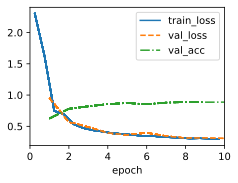

In [27]:
class NiN_fc(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.Flatten(),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

model = NiN_fc(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

In [30]:
model = NiN_fc()
X = torch.randn((1, 3, 224, 224), requires_grad=True)

_ = model(X)
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Sequential: 2-1                   [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 54, 54]          34,944
|    |    └─ReLU: 3-2                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-3                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-4                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-5                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-6                    [-1, 96, 54, 54]          --
|    └─MaxPool2d: 2-2                    [-1, 96, 26, 26]          --
|    └─Sequential: 2-3                   [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 26, 26]         614,656
|    |    └─ReLU: 3-8                    [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 256, 26, 26]         65,

c:\Users\Administrator.DESKTOP-II8P465\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Sequential: 2-1                   [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 54, 54]          34,944
|    |    └─ReLU: 3-2                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-3                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-4                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-5                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-6                    [-1, 96, 54, 54]          --
|    └─MaxPool2d: 2-2                    [-1, 96, 26, 26]          --
|    └─Sequential: 2-3                   [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 26, 26]         614,656
|    |    └─ReLU: 3-8                    [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 256, 26, 26]         65,

The training speed becomes slower. The accuracy increased. The number of parameters increased 2510.

### 4. Calculate the resource usage for NiN.

1. What is the number of parameters?
2. What is the amount of computation?
3. What is the amount of memory needed during training?
4. What is the amount of memory needed during prediction?

(1) number of parameters: 2015398

In [21]:
model = NiN()
X = torch.randn((1, 3, 224, 224), requires_grad=True)

_ = model(X)
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Sequential: 2-1                   [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 54, 54]          34,944
|    |    └─ReLU: 3-2                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-3                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-4                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-5                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-6                    [-1, 96, 54, 54]          --
|    └─MaxPool2d: 2-2                    [-1, 96, 26, 26]          --
|    └─Sequential: 2-3                   [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 26, 26]         614,656
|    |    └─ReLU: 3-8                    [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 256, 26, 26]         65,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Sequential: 2-1                   [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 54, 54]          34,944
|    |    └─ReLU: 3-2                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-3                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-4                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-5                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-6                    [-1, 96, 54, 54]          --
|    └─MaxPool2d: 2-2                    [-1, 96, 26, 26]          --
|    └─Sequential: 2-3                   [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 26, 26]         614,656
|    |    └─ReLU: 3-8                    [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 256, 26, 26]         65,

(2) the amount of computation:

In [23]:
from thop import profile
flops, params = profile(model, inputs=(X.to('cuda'),))
print("Total FLOPs:", flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
Total FLOPs: 1660084248.0


(3) the amount of memory needed during training:

Peak memory usage: 1394.40673828125 MB
Current memory usage: 191.4248046875 MB


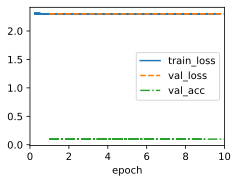

In [14]:
model = NiN(lr=0.05)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize memory counters
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
memory_stats = torch.cuda.memory_stats(device=device)
# Print peak memory usage and other memory statistics
print("Peak memory usage:", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("Current memory usage:", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

(4) the amount of memory needed during prediction

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
X = torch.randn((1, 1, 224, 224)).to('cuda')
_ = model(X)
memory_stats = torch.cuda.memory_stats(device=device)
print("Peak memory usage:", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("Current memory usage:", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

Peak memory usage: 327.6064453125 MB
Current memory usage: 200.7744140625 MB


### 5. What are possible problems with reducing the 384x5x5 representation to a 10x5x5 representation in one step?

Reducing the representation from 384 channels to only 10 channels in a single step can result in a significant loss of information.  Reducing the number of channels too quickly can limit the model’s ability to learn high-level features and hierarchical representations of the input data. But in NiN network, it just reduces the channels from 384 to 10 in one NiN block?

### 6. Use the structural design decisions in VGG that led to VGG-11, VGG-16, and VGG-19 to design a family of NiN-like networks.

In [19]:
def str_nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

class str_NiN(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        layers = []
        for i in range(len(arch)-1):
            layers.append(nin_block(*arch[i]))
            layers.append(nn.MaxPool2d(3, stride=2))
        layers.append(nn.Dropout(0.5))
        layers.append(nin_block(*arch[-1]))
        layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        layers.append(nn.Flatten())
        self.net = nn.Sequential(*layers)
        self.net.apply(d2l.init_cnn)

arch = ((96,11,4,0),(256,5,1,2),(384,3,1,1),(10,3,1,1))
model = str_NiN(arch, lr=0.03)
X = torch.randn((1, 3, 224, 224), requires_grad=True)

_ = model(X)
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Sequential: 2-1                   [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 54, 54]          34,944
|    |    └─ReLU: 3-2                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-3                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-4                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-5                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-6                    [-1, 96, 54, 54]          --
|    └─MaxPool2d: 2-2                    [-1, 96, 26, 26]          --
|    └─Sequential: 2-3                   [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 26, 26]         614,656
|    |    └─ReLU: 3-8                    [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 256, 26, 26]         65,

c:\Users\Administrator.DESKTOP-II8P465\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Sequential: 2-1                   [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 54, 54]          34,944
|    |    └─ReLU: 3-2                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-3                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-4                    [-1, 96, 54, 54]          --
|    |    └─Conv2d: 3-5                  [-1, 96, 54, 54]          9,312
|    |    └─ReLU: 3-6                    [-1, 96, 54, 54]          --
|    └─MaxPool2d: 2-2                    [-1, 96, 26, 26]          --
|    └─Sequential: 2-3                   [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 26, 26]         614,656
|    |    └─ReLU: 3-8                    [-1, 256, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 256, 26, 26]         65,